In [1]:
from __future__ import annotations

from glob import glob
import re
from dataclasses import dataclass
from typing import List, Optional

import numpy as np
import pandas as pd
from lxml import etree

from llm_attr_inf.dataset.base import ProfileText, Dataset
from llm_attr_inf.dataset.attributes import AGE, GENDER


SEED = 42
MIN_BLOG_LEN = 300
TRUNC_LEN = 350

FILENAME_RE = re.compile(
    r".*/(\d+)\.(\w+)\.(\d+)\.([\w-]+)\.(\w+)\.xml"
)


@dataclass
class Blog:
    text: str
    date: str = ""

    def truncate(self, max_len: int) -> "Blog":
        """Hard truncate with a marker."""
        if len(self.text) > max_len:
            self.text = (
                self.text[:max_len]
                + "... [post truncated]"
            )
        return self


@dataclass
class Bin:
    gender: str
    low_age: Optional[int] = None
    high_age: Optional[int] = None


def get_blogs(
    filename: str,
    min_length: Optional[int] = None,
) -> List[Blog]:
    """
    Parse an XML blog file and return Blog objects.
    """
    parser = etree.XMLParser(
        recover=True,
        resolve_entities=False,
    )
    tree = etree.parse(filename, parser)

    texts = [x.text.strip() for x in tree.findall("post")]
    dates = [x.text.strip() for x in tree.findall("date")]

    if len(texts) == len(dates):
        blogs = [Blog(t, d) for t, d in zip(texts, dates)]
    else:
        blogs = [Blog(t) for t in texts]

    if min_length is not None:
        blogs = [b for b in blogs if len(b.text) > min_length]

    return blogs


def build_metadata_df(folder: str) -> pd.DataFrame:
    """
    Scan blog XML files and extract user metadata.
    """
    rows = []

    for filename in glob(f"{folder}/*"):
        match = FILENAME_RE.match(filename)
        if not match:
            continue

        blogs = get_blogs(filename)

        rows.append({
            "user_id": match.group(1),
            "gender": match.group(2),
            "age": int(match.group(3)),
            "industry": match.group(4),
            "zodiac": match.group(5),
            "filename": filename,
            "max_length": max(len(b.text) for b in blogs),
            "lengths": [len(b.text) for b in blogs]
        })

    return pd.DataFrame(rows)

In [2]:
data_folder="data/blogs"
output_dir="outputs/data/blogs"
num_sample=600
min_blog_len=300
trunc_len=350
seed=42

In [3]:
df_meta = build_metadata_df(data_folder)

In [6]:
min_length = 200
max_length = 600

# count profiles where only blogs within the length range exist
def count_profiles_in_length_range(
    df: pd.DataFrame,
    min_length: int,
    max_length: int
) -> int:
    count = 0
    for _, row in df.iterrows():
        lengths = row['lengths']
        if all(min_length <= length <= max_length for length in lengths):
            count += 1
    return count

In [7]:
count_profiles_in_length_range(df_meta, min_length, max_length)

44

In [11]:
len(df_meta[df_meta["age"] >= 40]) / len(df_meta) * 100 

4.886128364389234

48

(array([145., 139., 127., 116.,  94., 103.,  72.,  71.,  77.,   0.]),
 array([40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <BarContainer object of 10 artists>)

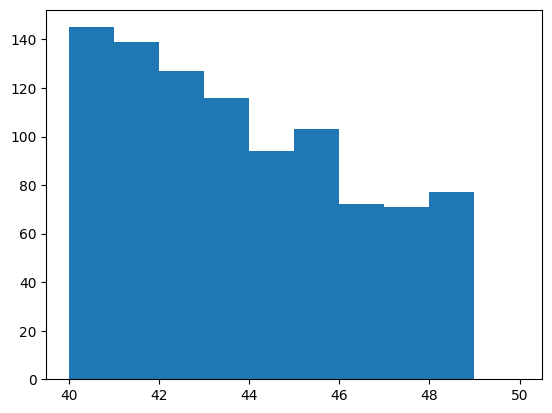

In [18]:
import matplotlib.pyplot as plt
plt.hist(df_meta[df_meta["age"] >= 40]["age"], bins=list(range(40, 51)))

(array([5859., 2381., 2026., 4855., 1205.,  464., 1263.,  468.,  476.,
         323.]),
 array([13. , 16.5, 20. , 23.5, 27. , 30.5, 34. , 37.5, 41. , 44.5, 48. ]),
 <BarContainer object of 10 artists>)

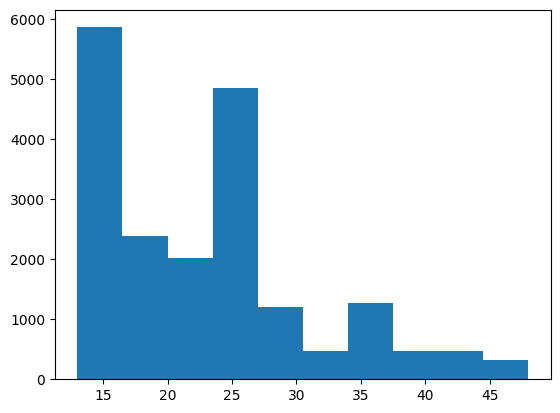

In [19]:
plt.hist(df_meta["age"])